In [22]:
import numpy as np
import random
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt 
import matplotlib as mpl
from cycler import cycler



import neuralnetworks 
import analysis_tools 



font = {'family' : 'Tahoma',
        'size'   : 15}
mpl.rc('font', **font) 
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])

mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10)




# Loading the data of the MNIST data set 

In [3]:
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

# Define deep learning model, loss function and optimizer 

In [4]:

model = neuralnetworks.CNN_digitrec()  

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model 

In [5]:

num_epochs = 10

early_stopping = analysis_tools.EarlyStopping(patience=2, delta=0.01)


train_acc = []
test_acc = []
test_loss = []
train_loss = []

# Training 
for epoch in range(num_epochs):  
    
    train_accuracy = 0 
    model.train()
    train_loss_tmp = 0 

    total = len(mnist_train)
    for images, labels in train_loader:

        # Set gradients to zero 
        optimizer.zero_grad()

        # Forward pass
        x = images   
        y = model(x)
        loss = criterion(y, labels)
        # Backward pass
        loss.backward()
        optimizer.step()


        # Calculate accuracy 
        predictions = torch.argmax(y, dim=1)
        train_accuracy += torch.sum((predictions == labels).float())
        train_loss_tmp += criterion(y, labels).item() * labels.size(0)
      
    train_accuracy /= total 
    train_acc.append(train_accuracy)
    train_loss_tmp /= total 
    train_loss.append(train_loss_tmp)
        
    # Testing
    test_accuracy = 0
    test_loss_tmp = 0 
    total = len(mnist_test)

    model.eval() 

    with torch.no_grad():
        for images, labels in test_loader:
            x = images 
            y = model(x)

            predictions = torch.argmax(y, dim=1)
            test_accuracy += torch.sum((predictions == labels).float())
            test_loss_tmp += criterion(y, labels).item() * labels.size(0)

    test_loss_tmp /= total
    test_accuracy /= total 
    test_acc.append(test_accuracy)
    test_loss.append(test_loss_tmp)
    
    print(f'Epoch {epoch+1}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {test_accuracy:.4f}')

    early_stopping.check(test_loss_tmp, model)
    if early_stopping.early_stop:
        print(f"The training of the model is stopped after {epoch+1} epochs, to prevent overfitting...")
        break


Epoch 1, Training Accuracy: 0.9240, Validation Accuracy: 0.9700
Epoch 2, Training Accuracy: 0.9736, Validation Accuracy: 0.9765
Epoch 3, Training Accuracy: 0.9815, Validation Accuracy: 0.9802
Epoch 4, Training Accuracy: 0.9861, Validation Accuracy: 0.9803
Epoch 5, Training Accuracy: 0.9887, Validation Accuracy: 0.9796
The training of the model is stopped after 5 epochs, to prevent overfitting...


# Accuracy and Loss plots 

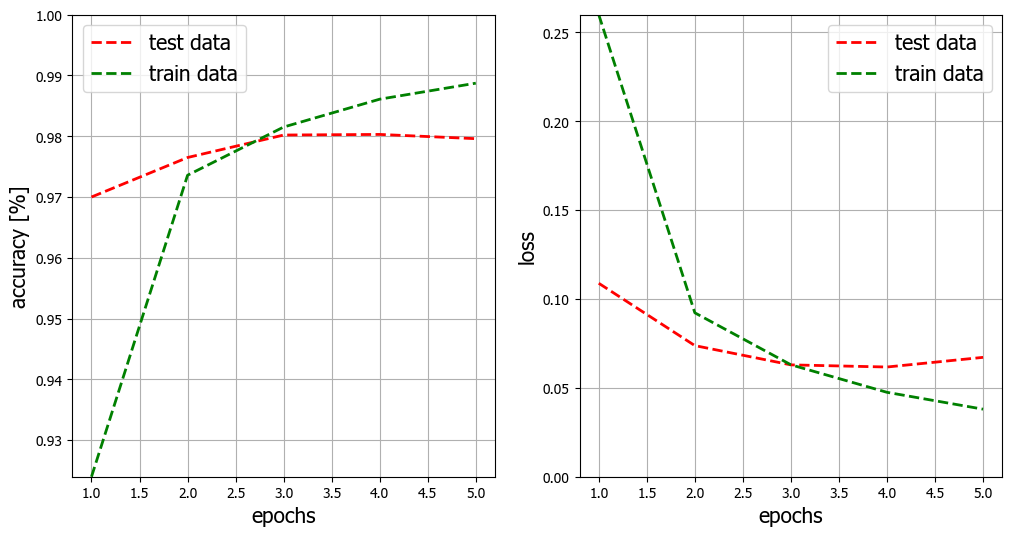

In [10]:


epochs = [ i+1 for i in range(epoch+1)]
fig, axs = plt.subplots(1,2, figsize =(12,6))
axs[0].plot(epochs,test_acc, label = 'test data' )
axs[0].plot(epochs, train_acc, label = 'train data')
axs[0].set_ylim(min(train_acc), 1)
axs[0].set_ylabel("accuracy [%]")
axs[0].legend()
axs[0].set_xlabel("epochs")
axs[0].grid()


axs[1].plot(epochs,test_loss, label = 'test data' )
axs[1].plot(epochs, train_loss, label = 'train data')
axs[1].set_ylim(0, max(train_loss))
axs[1].set_ylabel("loss")
axs[1].legend()
axs[1].set_xlabel("epochs")
axs[1].grid()

# Example image

Text(0.5, 1.0, 'True:6 \n NN:6')

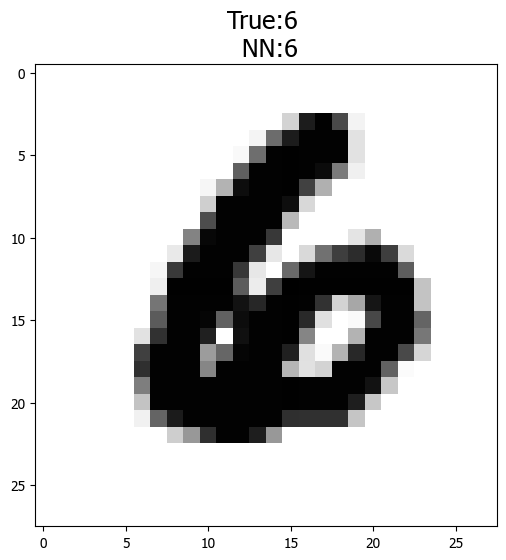

In [61]:
#plot example 
images, labels = next(iter(train_loader))

#take a random example from the first batch
rand_idx = random.randint(0, images.shape[0])

image  = images[rand_idx].view(28,28)
plt.figure(figsize = (6,6))
plt.imshow(image, cmap = 'gray_r')
nn_output = model(images[rand_idx])
nn_label = torch.argmax(nn_output, dim=1).item()
plt.title(f"True:{labels[rand_idx]} \n NN:{nn_label}")
